Import important parameter

In [1]:
inputsize =25**2
e = 0.05

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <10000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)
sqrtinputsize = int(np.sqrt(inputsize))     
sqrtoutputsize = int(sqrtinputsize/2)
outputsize = int(sqrtoutputsize**2)
h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R = Restriction(inputsize)
P = 4*np.transpose(R)

Linear = 0.8031677915714609


GMM on fine grid

In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 13.477008982954695
Interation = 1
Residual = 1.659077266819512
Interation = 2
Residual = 0.3953757144505127
Interation = 3
Residual = 0.11246304491282305
Interation = 4
Residual = 0.037159864797617695
Interation = 5
Residual = 0.013444737618084516
Interation = 6
Residual = 0.005097808917627252
Interation = 7
Residual = 0.0019802348243906226
Interation = 8
Residual = 0.0007796604438115129
Interation = 9
Residual = 0.00030953866330129024
Interation = 10
Residual = 0.00012359797900948066
Interation = 11
Residual = 4.9566125060918015e-05
Interation = 12
Residual = 1.9947474421469467e-05
Interation = 13
Residual = 8.052138216408959e-06
Interation = 14
Residual = 3.2592959450168673e-06
Interation = 15
Residual = 1.3226377684627352e-06
Interation = 16
Residual = 5.380305739722609e-07
Interation = 17
Residual = 2.193740697488632e-07
Interation = 18
Residual = 8.965037406132655e-08
Interation = 19
Residual = 3.671911657568232e-08
Interation = 20
Residual = 1.507288103083036e-08
Inter

Error GMM on fine grid

In [6]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
2.314497705818638
L2 norm: 
0.14626732909197623
H1 norm: 
1.7191512872329884
Energy norm: 
0.18238840145919555
L2 norm: 
0.29253465818395247
H1 norm: 
0.19112563416393225


Solution

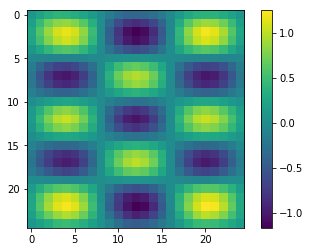

In [7]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

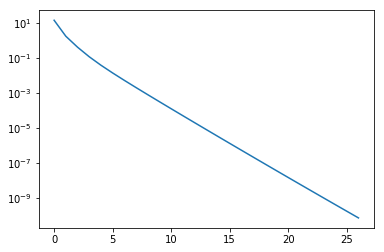

In [8]:
plt.semilogy(GMM_Res)

Radius

In [9]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.44816939625637175


Global DMM optimization

In [10]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-4,accept_radius =
                                                           GMM_Radius*10,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.45073979429911937
L = 0.03
rho = 0.4506848299477141
L = 0.04
rho = 0.4506263410590995
L = 0.05
rho = 0.4505645495991572
L = 0.060000000000000005
rho = 0.450499670213852
L = 0.07
rho = 0.4504319100215958
L = 0.08
rho = 0.4503614684967645
L = 0.09
rho = 0.4502885374274383
L = 0.09999999999999999
rho = 0.45021330093323964
L = 0.10999999999999999
rho = 0.45013593553148834
L = 0.11999999999999998
rho = 0.45005661024186383
L = 0.12999999999999998
rho = 0.4499754867214195
L = 0.13999999999999999
rho = 0.44989271942317777
L = 0.15
rho = 0.44980845577269585
L = 0.16
rho = 0.44972283635796895
L = 0.17
rho = 0.4496359951288443
L = 0.18000000000000002
rho = 0.4495480596028122
L = 0.19000000000000003
rho = 0.4494591510745989
L = 0.20000000000000004
rho = 0.449369384827471
L = 0.21000000000000005
rho = 0.449278870344555
L = 0.22000000000000006
rho = 0.44918771151880693
L = 0.23000000000000007
rho = 0.44909600686054646
L = 0.24000000000000007
rho = 0.44900384970

the 27 steps
rho = 0.4420537570388899
the 28 steps
rho = 0.4420059263056933
the 29 steps
rho = 0.4419581014275389
the 30 steps
rho = 0.4419102823898871
the 31 steps
rho = 0.4418624691792042
the 32 steps
rho = 0.4418146617828721
the 33 steps
rho = 0.4417668601891092
the 34 steps
rho = 0.4417190643868965
the 35 steps
rho = 0.4416712743659116
the 36 steps
rho = 0.4416234901164682
the 37 steps
rho = 0.4415757116294612
the 38 steps
rho = 0.4415279388963175
the 39 steps
rho = 0.4414801719089498
the 40 steps
rho = 0.441432410659716
the 41 steps
rho = 0.44138465514138187
the 42 steps
rho = 0.4413369053470866
the 43 steps
rho = 0.441289161270312
the 44 steps
rho = 0.4412414229048548
the 45 steps
rho = 0.44119369024480043
the 46 steps
rho = 0.4411459632845002
the 47 steps
rho = 0.44109824201854947
the 48 steps
rho = 0.44105052644176934
the 49 steps
rho = 0.4410028165491883
the 50 steps
rho = 0.44095511233602624
the 51 steps
rho = 0.44090741379768017
the 52 steps
rho = 0.44085972092971093
the 53 

the 167 steps
rho = 0.43541216992569237
the 168 steps
rho = 0.43536511850934156
the 169 steps
rho = 0.4353180725286925
the 170 steps
rho = 0.4352710319825372
the 171 steps
rho = 0.43522399686967334
the 172 steps
rho = 0.4351769671889046
the 173 steps
rho = 0.4351299429390404
the 174 steps
rho = 0.43508292411889565
the 175 steps
rho = 0.4350359107272911
the 176 steps
rho = 0.4349889027630527
the 177 steps
rho = 0.43494190022501217
the 178 steps
rho = 0.4348949031120063
the 179 steps
rho = 0.43484791142287754
the 180 steps
rho = 0.4348009251564732
the 181 steps
rho = 0.43475394431164605
the 182 steps
rho = 0.4347069688872537
the 183 steps
rho = 0.43465999888215906
the 184 steps
rho = 0.43461303429522985
the 185 steps
rho = 0.4345660751253388
the 186 steps
rho = 0.43451912137136356
the 187 steps
rho = 0.43447217303218627
the 188 steps
rho = 0.43442523010669426
the 189 steps
rho = 0.43437829259377897
the 190 steps
rho = 0.43433136049233717
the 191 steps
rho = 0.43428443380126946
the 192 st

the 305 steps
rho = 0.4289700038701682
the 306 steps
rho = 0.42892369291861154
the 307 steps
rho = 0.4288773872708656
the 308 steps
rho = 0.4288310869261337
the 309 steps
rho = 0.42878479188362073
the 310 steps
rho = 0.42873850214253284
the 311 steps
rho = 0.4286922177020778
the 312 steps
rho = 0.4286459385614646
the 313 steps
rho = 0.4285996647199035
the 314 steps
rho = 0.4285533961766063
the 315 steps
rho = 0.42850713293078624
the 316 steps
rho = 0.42846087498165736
the 317 steps
rho = 0.42841462232843575
the 318 steps
rho = 0.4283683749703382
the 319 steps
rho = 0.42832213290658316
the 320 steps
rho = 0.4282758961363902
the 321 steps
rho = 0.42822966465898044
the 322 steps
rho = 0.42818343847357576
the 323 steps
rho = 0.4281372175793997
the 324 steps
rho = 0.428091001975677
the 325 steps
rho = 0.42804479166163373
the 326 steps
rho = 0.42799858663649676
the 327 steps
rho = 0.42795238689949455
the 328 steps
rho = 0.4279061924498569
the 329 steps
rho = 0.4278600032868143
the 330 steps


the 444 steps
rho = 0.4225833187675723
the 445 steps
rho = 0.42253773788807064
the 446 steps
rho = 0.4224921622114167
the 447 steps
rho = 0.4224465917369348
the 448 steps
rho = 0.42240102646394945
the 449 steps
rho = 0.4223554663917861
the 450 steps
rho = 0.42230991151977054
the 451 steps
rho = 0.422264361847229
the 452 steps
rho = 0.42221881737348815
the 453 steps
rho = 0.42217327809787525
the 454 steps
rho = 0.42212774401971814
the 455 steps
rho = 0.42208221513834493
the 456 steps
rho = 0.4220366914530844
the 457 steps
rho = 0.42199117296326566
the 458 steps
rho = 0.4219456596682183
the 459 steps
rho = 0.42190015156727234
the 460 steps
rho = 0.4218546486597586
the 461 steps
rho = 0.42180915094500787
the 462 steps
rho = 0.42176365842235175
the 463 steps
rho = 0.4217181710911221
the 464 steps
rho = 0.42167268895065146
the 465 steps
rho = 0.42162721200027253
the 466 steps
rho = 0.42158174023931877
the 467 steps
rho = 0.42153627366712393
the 468 steps
rho = 0.42149081228302204
the 469 st

the 582 steps
rho = 0.4163420565251468
the 583 steps
rho = 0.4162971874269761
the 584 steps
rho = 0.4162523234420366
the 585 steps
rho = 0.41620746456969904
the 586 steps
rho = 0.41616261080933425
the 587 steps
rho = 0.41611776216031343
the 588 steps
rho = 0.416072918622008
the 589 steps
rho = 0.4160280801937896
the 590 steps
rho = 0.41598324687502974
the 591 steps
rho = 0.4159384186651009
the 592 steps
rho = 0.41589359556337474
the 593 steps
rho = 0.41584877756922406
the 594 steps
rho = 0.4158039646820214
the 595 steps
rho = 0.41575915690113957
the 596 steps
rho = 0.4157143542259515
the 597 steps
rho = 0.4156695566558306
the 598 steps
rho = 0.4156247641901503
the 599 steps
rho = 0.41557997682828407
the 600 steps
rho = 0.41553519456960575
the 601 steps
rho = 0.4154904174134896
the 602 steps
rho = 0.4154456453593096
the 603 steps
rho = 0.4154008784064403
the 604 steps
rho = 0.41535611655425625
the 605 steps
rho = 0.41531135980213235
the 606 steps
rho = 0.4152666081494435
the 607 steps
r

the 720 steps
rho = 0.4101981893856177
the 721 steps
rho = 0.41015402004205825
the 722 steps
rho = 0.41010985572649755
the 723 steps
rho = 0.4100656964383272
the 724 steps
rho = 0.4100215421769389
the 725 steps
rho = 0.4099773929417245
the 726 steps
rho = 0.40993324873207587
the 727 steps
rho = 0.40988910954738494
the 728 steps
rho = 0.409844975387044
the 729 steps
rho = 0.40980084625044505
the 730 steps
rho = 0.40975672213698067
the 731 steps
rho = 0.4097126030460429
the 732 steps
rho = 0.4096684889770245
the 733 steps
rho = 0.40962437992931794
the 734 steps
rho = 0.4095802759023161
the 735 steps
rho = 0.40953617689541155
the 736 steps
rho = 0.4094920829079973
the 737 steps
rho = 0.40944799393946635
the 738 steps
rho = 0.40940390998921167
the 739 steps
rho = 0.40935983105662643
the 740 steps
rho = 0.4093157571411041
the 741 steps
rho = 0.4092716882420378
the 742 steps
rho = 0.4092276243588212
the 743 steps
rho = 0.4091835654908478
the 744 steps
rho = 0.409139511637511
the 745 steps
rh

the 858 steps
rho = 0.40415009021716436
the 859 steps
rho = 0.4041066090232063
the 860 steps
rho = 0.40406313277405753
the 861 steps
rho = 0.4040196614691197
the 862 steps
rho = 0.40397619510779453
the 863 steps
rho = 0.40393273368948374
the 864 steps
rho = 0.40388927721358875
the 865 steps
rho = 0.4038458256795115
the 866 steps
rho = 0.40380237908665395
the 867 steps
rho = 0.40375893743441765
the 868 steps
rho = 0.4037155007222048
the 869 steps
rho = 0.40367206894941715
the 870 steps
rho = 0.40362864211545674
the 871 steps
rho = 0.4035852202197256
the 872 steps
rho = 0.40354180326162575
the 873 steps
rho = 0.4034983912405593
the 874 steps
rho = 0.4034549841559286
the 875 steps
rho = 0.4034115820071357
the 876 steps
rho = 0.40336818479358294
the 877 steps
rho = 0.40332479251467246
the 878 steps
rho = 0.4032814051698068
the 879 steps
rho = 0.40323802275838816
the 880 steps
rho = 0.4031946452798191
the 881 steps
rho = 0.40315127273350193
the 882 steps
rho = 0.4031079051188393
the 883 ste

the 997 steps
rho = 0.39815336840789617
the 998 steps
rho = 0.3981105688194009
the 999 steps
rho = 0.3980677740928644
the 1000 steps
rho = 0.3980249842276924
the 1001 steps
rho = 0.39798219922329003
the 1002 steps
rho = 0.3979394190790634
the 1003 steps
rho = 0.39789664379441764
the 1004 steps
rho = 0.3978538733687586
the 1005 steps
rho = 0.39781110780149165
the 1006 steps
rho = 0.3977683470920224
the 1007 steps
rho = 0.3977255912397565
the 1008 steps
rho = 0.39768284024409967
the 1009 steps
rho = 0.39764009410445733
the 1010 steps
rho = 0.3975973528202352
the 1011 steps
rho = 0.397554616390839
the 1012 steps
rho = 0.3975118848156742
the 1013 steps
rho = 0.3974691580941465
the 1014 steps
rho = 0.39742643622566176
the 1015 steps
rho = 0.3973837192096254
the 1016 steps
rho = 0.39734100704544323
the 1017 steps
rho = 0.39729829973252084
the 1018 steps
rho = 0.397255597270264
the 1019 steps
rho = 0.39721289965807843
the 1020 steps
rho = 0.39717020689536975
the 1021 steps
rho = 0.39712751898

the 1133 steps
rho = 0.3923770134670888
the 1134 steps
rho = 0.3923348696492229
the 1135 steps
rho = 0.39229273061247766
the 1136 steps
rho = 0.3922505963562584
the 1137 steps
rho = 0.39220846687997024
the 1138 steps
rho = 0.39216634218301777
the 1139 steps
rho = 0.3921242222648063
the 1140 steps
rho = 0.3920821071247405
the 1141 steps
rho = 0.3920399967622255
the 1142 steps
rho = 0.39199789117666606
the 1143 steps
rho = 0.391955790367467
the 1144 steps
rho = 0.3919136943340334
the 1145 steps
rho = 0.39187160307576996
the 1146 steps
rho = 0.3918295165920813
the 1147 steps
rho = 0.3917874348823726
the 1148 steps
rho = 0.3917453579460484
the 1149 steps
rho = 0.3917032857825135
the 1150 steps
rho = 0.39166121839117257
the 1151 steps
rho = 0.3916191557714305
the 1152 steps
rho = 0.3915770979226917
the 1153 steps
rho = 0.39153504484436114
the 1154 steps
rho = 0.3914929965358433
the 1155 steps
rho = 0.39145095299654287
the 1156 steps
rho = 0.39140891422586443
the 1157 steps
rho = 0.391366880

the 1269 steps
rho = 0.3866891006354319
the 1270 steps
rho = 0.3866476015777745
the 1271 steps
rho = 0.38660610722007066
the 1272 steps
rho = 0.3865646175617212
the 1273 steps
rho = 0.38652313260212684
the 1274 steps
rho = 0.38648165234068815
the 1275 steps
rho = 0.38644017677680587
the 1276 steps
rho = 0.3863987059098807
the 1277 steps
rho = 0.38635723973931285
the 1278 steps
rho = 0.3863157782645032
the 1279 steps
rho = 0.38627432148485197
the 1280 steps
rho = 0.3862328693997596
the 1281 steps
rho = 0.38619142200862655
the 1282 steps
rho = 0.3861499793108531
the 1283 steps
rho = 0.3861085413058395
the 1284 steps
rho = 0.3860671079929861
the 1285 steps
rho = 0.386025679371693
the 1286 steps
rho = 0.3859842554413604
the 1287 steps
rho = 0.38594283620138836
the 1288 steps
rho = 0.38590142165117697
the 1289 steps
rho = 0.38586001179012636
the 1290 steps
rho = 0.3858186066176363
the 1291 steps
rho = 0.3857772061331068
the 1292 steps
rho = 0.38573581033593785
the 1293 steps
rho = 0.3856944

the 1405 steps
rho = 0.3810881280516618
the 1406 steps
rho = 0.3810472626686613
the 1407 steps
rho = 0.3810064019037298
the 1408 steps
rho = 0.38096554575626407
the 1409 steps
rho = 0.3809246942256598
the 1410 steps
rho = 0.38088384731131336
the 1411 steps
rho = 0.38084300501262075
the 1412 steps
rho = 0.38080216732897837
the 1413 steps
rho = 0.3807613342597823
the 1414 steps
rho = 0.380720505804429
the 1415 steps
rho = 0.3806796819623147
the 1416 steps
rho = 0.3806388627328359
the 1417 steps
rho = 0.3805980481153889
the 1418 steps
rho = 0.3805572381093702
the 1419 steps
rho = 0.3805164327141765
the 1420 steps
rho = 0.3804756319292044
the 1421 steps
rho = 0.38043483575385034
the 1422 steps
rho = 0.38039404418751144
the 1423 steps
rho = 0.38035325722958435
the 1424 steps
rho = 0.3803124748794659
the 1425 steps
rho = 0.3802716971365532
the 1426 steps
rho = 0.3802309240002434
the 1427 steps
rho = 0.3801901554699336
the 1428 steps
rho = 0.38014939154502114
the 1429 steps
rho = 0.3801086322

the 1541 steps
rho = 0.3755725855437142
the 1542 steps
rho = 0.37553234283078324
the 1543 steps
rho = 0.37549210466043265
the 1544 steps
rho = 0.3754518710323174
the 1545 steps
rho = 0.3754116419461025
the 1546 steps
rho = 0.3753714174014626
the 1547 steps
rho = 0.3753311973980824
the 1548 steps
rho = 0.37529098193565735
the 1549 steps
rho = 0.375250771013894
the 1550 steps
rho = 0.37521056463251035
the 1551 steps
rho = 0.37517036279123583
the 1552 steps
rho = 0.3751301654898126
the 1553 steps
rho = 0.3750899727279949
the 1554 steps
rho = 0.3750497845055506
the 1555 steps
rho = 0.3750096008222608
the 1556 steps
rho = 0.3749694216779208
the 1557 steps
rho = 0.3749292470723405
the 1558 steps
rho = 0.37488907700534463
the 1559 steps
rho = 0.3748489114767739
the 1560 steps
rho = 0.37480875048648493
the 1561 steps
rho = 0.3747685940343513
the 1562 steps
rho = 0.3747284421202638
the 1563 steps
rho = 0.3746882947441311
the 1564 steps
rho = 0.3746481519058808
the 1565 steps
rho = 0.37460801360

the 1677 steps
rho = 0.37014161343617175
the 1678 steps
rho = 0.37010200616946576
the 1679 steps
rho = 0.3700624042210233
the 1680 steps
rho = 0.37002280762069895
the 1681 steps
rho = 0.3699832163994108
the 1682 steps
rho = 0.3699436305891782
the 1683 steps
rho = 0.36990405022315853
the 1684 steps
rho = 0.369864475335688
the 1685 steps
rho = 0.3698249059623213
the 1686 steps
rho = 0.36978534213987435
the 1687 steps
rho = 0.3697457839064675
the 1688 steps
rho = 0.3697062313015707
the 1689 steps
rho = 0.36966668436605016
the 1690 steps
rho = 0.36962714314221645
the 1691 steps
rho = 0.3695876076738743
the 1692 steps
rho = 0.369548078006374
the 1693 steps
rho = 0.3695085541866652
the 1694 steps
rho = 0.3694690362633509
the 1695 steps
rho = 0.36942952428674547
the 1696 steps
rho = 0.3693900183089331
the 1697 steps
rho = 0.3693505183838282
the 1698 steps
rho = 0.3693110245672393
the 1699 steps
rho = 0.36927153691693304
the 1700 steps
rho = 0.3692320554927022
the 1701 steps
rho = 0.3691925803

the 1813 steps
rho = 0.3648649215933562
the 1814 steps
rho = 0.36482835787428614
the 1815 steps
rho = 0.3647918786857063
the 1816 steps
rho = 0.36475548645174716
the 1817 steps
rho = 0.36471918365876377
the 1818 steps
rho = 0.3646829728562234
the 1819 steps
rho = 0.3646468566575551
the 1820 steps
rho = 0.3646108377409591
the 1821 steps
rho = 0.3645749188501709
the 1822 steps
rho = 0.36453910279517315
the 1823 steps
rho = 0.3645033924528541
the 1824 steps
rho = 0.36446779076760494
the 1825 steps
rho = 0.3644323007518499
the 1826 steps
rho = 0.36439692548650654
the 1827 steps
rho = 0.3643616681213667
the 1828 steps
rho = 0.36432653187539515
the 1829 steps
rho = 0.36429152003693643
the 1830 steps
rho = 0.3642566359638264
the 1831 steps
rho = 0.36422188308339926
the 1832 steps
rho = 0.3641872648923845
the 1833 steps
rho = 0.36415278495668607
the 1834 steps
rho = 0.3641184469110355
the 1835 steps
rho = 0.36408425445851356
the 1836 steps
rho = 0.3640502113699304
the 1837 steps
rho = 0.364016

the 1949 steps
rho = 0.36194796266290635
the 1950 steps
rho = 0.3619444893022904
the 1951 steps
rho = 0.3619411413078631
the 1952 steps
rho = 0.36193791438242184
the 1953 steps
rho = 0.3619348043258648
the 1954 steps
rho = 0.36193180703625966
the 1955 steps
rho = 0.3619289185106517
the 1956 steps
rho = 0.3619261348456232
the 1957 steps
rho = 0.3619234522376186
the 1958 steps
rho = 0.3619208669830471
the 1959 steps
rho = 0.36191837547817446
the 1960 steps
rho = 0.36191597421881944
the 1961 steps
rho = 0.36191365979986584
the 1962 steps
rho = 0.3619114289146022
the 1963 steps
rho = 0.36190927835390385
the 1964 steps
rho = 0.361907205005267
the 1965 steps
rho = 0.3619052058517087
the 1966 steps
rho = 0.36190327797054345
the 1967 steps
rho = 0.361901418532047
the 1968 steps
rho = 0.3618996247980195
the 1969 steps
rho = 0.3618978941202585
the 1970 steps
rho = 0.3618962239389502
the 1971 steps
rho = 0.3618946117809899
the 1972 steps
rho = 0.3618930552582411
the 1973 steps
rho = 0.36189155206

the 2085 steps
rho = 0.3618268578877632
the 2086 steps
rho = 0.36182647797103895
the 2087 steps
rho = 0.36182609824015866
the 2088 steps
rho = 0.36182571868550284
the 2089 steps
rho = 0.36182533929792454
the 2090 steps
rho = 0.36182496006872483
the 2091 steps
rho = 0.361824580989631
the 2092 steps
rho = 0.3618242020527738
the 2093 steps
rho = 0.3618238232506676
the 2094 steps
rho = 0.36182344457619053
the 2095 steps
rho = 0.3618230660225662
the 2096 steps
rho = 0.3618226875833458
the 2097 steps
rho = 0.3618223092523916
the 2098 steps
rho = 0.36182193102386134
the 2099 steps
rho = 0.3618215528921924
the 2100 steps
rho = 0.36182117485208837
the 2101 steps
rho = 0.36182079689850527
the 2102 steps
rho = 0.36182041902663814
the 2103 steps
rho = 0.36182004123190953
the 2104 steps
rho = 0.36181966350995765
the 2105 steps
rho = 0.3618192858566252
the 2106 steps
rho = 0.36181890826794944
the 2107 steps
rho = 0.36181853074015136
the 2108 steps
rho = 0.3618181532696272
the 2109 steps
rho = 0.3618

the 2221 steps
rho = 0.36177549953541155
the 2222 steps
rho = 0.36177512058634204
the 2223 steps
rho = 0.361774741595972
the 2224 steps
rho = 0.3617743625639863
the 2225 steps
rho = 0.36177398349007095
the 2226 steps
rho = 0.3617736043739125
the 2227 steps
rho = 0.36177322521519806
the 2228 steps
rho = 0.36177284601361553
the 2229 steps
rho = 0.3617724667688535
the 2230 steps
rho = 0.3617720874806008
the 2231 steps
rho = 0.36177170814854726
the 2232 steps
rho = 0.36177132877238305
the 2233 steps
rho = 0.361770949351799
the 2234 steps
rho = 0.3617705698864861
the 2235 steps
rho = 0.3617701903761364
the 2236 steps
rho = 0.36176981082044196
the 2237 steps
rho = 0.3617694312190957
the 2238 steps
rho = 0.36176905157179073
the 2239 steps
rho = 0.36176867187822087
the 2240 steps
rho = 0.36176829213808
the 2241 steps
rho = 0.36176791235106265
the 2242 steps
rho = 0.36176753251686405
the 2243 steps
rho = 0.3617671526351791
the 2244 steps
rho = 0.36176677270570395
the 2245 steps
rho = 0.36176639

the 2357 steps
rho = 0.3617234595981839
the 2358 steps
rho = 0.36172307228869943
the 2359 steps
rho = 0.36172268489798026
the 2360 steps
rho = 0.3617222974257478
the 2361 steps
rho = 0.36172190987172387
the 2362 steps
rho = 0.36172152223563053
the 2363 steps
rho = 0.36172113451718996
the 2364 steps
rho = 0.361720746716125
the 2365 steps
rho = 0.36172035883215836
the 2366 steps
rho = 0.3617199708650133
the 2367 steps
rho = 0.3617195828144133
the 2368 steps
rho = 0.361719194680082
the 2369 steps
rho = 0.3617188064617436
the 2370 steps
rho = 0.36171841815912265
the 2371 steps
rho = 0.36171802977194334
the 2372 steps
rho = 0.36171764129993117
the 2373 steps
rho = 0.3617172527428111
the 2374 steps
rho = 0.3617168641003089
the 2375 steps
rho = 0.36171647537215057
the 2376 steps
rho = 0.36171608655806237
the 2377 steps
rho = 0.36171569765777084
the 2378 steps
rho = 0.3617153086710028
the 2379 steps
rho = 0.3617149195974858
the 2380 steps
rho = 0.36171453043694723
the 2381 steps
rho = 0.361714

the 2493 steps
rho = 0.361669930742909
the 2494 steps
rho = 0.3616695299979759
the 2495 steps
rho = 0.3616691291382719
the 2496 steps
rho = 0.36166872816360096
the 2497 steps
rho = 0.3616683270737683
the 2498 steps
rho = 0.36166792586858026
the 2499 steps
rho = 0.36166752454784423
the 2500 steps
rho = 0.3616671231113684
the 2501 steps
rho = 0.36166672155896273
the 2502 steps
rho = 0.3616663198904378
the 2503 steps
rho = 0.3616659181056052
the 2504 steps
rho = 0.36166551620427856
the 2505 steps
rho = 0.3616651141862717
the 2506 steps
rho = 0.36166471205139994
the 2507 steps
rho = 0.36166430979947983
the 2508 steps
rho = 0.3616639074303291
the 2509 steps
rho = 0.3616635049437669
the 2510 steps
rho = 0.361663102339613
the 2511 steps
rho = 0.3616626996176889
the 2512 steps
rho = 0.3616622967778173
the 2513 steps
rho = 0.3616618938198218
the 2514 steps
rho = 0.3616614907435275
the 2515 steps
rho = 0.3616610875487608
the 2516 steps
rho = 0.3616606842353494
the 2517 steps
rho = 0.361660280803

the 2629 steps
rho = 0.3616143141250575
the 2630 steps
rho = 0.36161389656732007
the 2631 steps
rho = 0.3616134788828396
the 2632 steps
rho = 0.3616130610716815
the 2633 steps
rho = 0.36161264313391417
the 2634 steps
rho = 0.36161222506960905
the 2635 steps
rho = 0.3616118068788408
the 2636 steps
rho = 0.36161138856168695
the 2637 steps
rho = 0.3616109701182284
the 2638 steps
rho = 0.3616105515485489
the 2639 steps
rho = 0.3616101328527355
the 2640 steps
rho = 0.3616097140308786
the 2641 steps
rho = 0.36160929508307155
the 2642 steps
rho = 0.361608876009411
the 2643 steps
rho = 0.361608456809997
the 2644 steps
rho = 0.36160803748493264
the 2645 steps
rho = 0.36160761803432434
the 2646 steps
rho = 0.361607198458282
the 2647 steps
rho = 0.36160677875691877
the 2648 steps
rho = 0.36160635893035115
the 2649 steps
rho = 0.36160593897869886
the 2650 steps
rho = 0.3616055189020852
the 2651 steps
rho = 0.36160509870063706
the 2652 steps
rho = 0.3616046783744846
the 2653 steps
rho = 0.361604257

the 2765 steps
rho = 0.36155643952639566
the 2766 steps
rho = 0.36155600691044687
the 2767 steps
rho = 0.3615555742150096
the 2768 steps
rho = 0.3615551414408149
the 2769 steps
rho = 0.3615547085886009
the 2770 steps
rho = 0.36155427565911363
the 2771 steps
rho = 0.3615538426531061
the 2772 steps
rho = 0.3615534095713388
the 2773 steps
rho = 0.36155297641458034
the 2774 steps
rho = 0.3615525431836062
the 2775 steps
rho = 0.36155210987919967
the 2776 steps
rho = 0.36155167650215225
the 2777 steps
rho = 0.3615512430532625
the 2778 steps
rho = 0.36155080953333707
the 2779 steps
rho = 0.3615503759431903
the 2780 steps
rho = 0.3615499422836446
the 2781 steps
rho = 0.36154950855553014
the 2782 steps
rho = 0.36154907475968523
the 2783 steps
rho = 0.3615486408969558
the 2784 steps
rho = 0.3615482069681963
the 2785 steps
rho = 0.3615477729742691
the 2786 steps
rho = 0.3615473389160449
the 2787 steps
rho = 0.3615469047944023
the 2788 steps
rho = 0.3615464706102286
the 2789 steps
rho = 0.36154603

the 2901 steps
rho = 0.3614972930174177
the 2902 steps
rho = 0.3614968600573686
the 2903 steps
rho = 0.36149642720805253
the 2904 steps
rho = 0.3614959944717629
the 2905 steps
rho = 0.36149556185081005
the 2906 steps
rho = 0.3614951293475213
the 2907 steps
rho = 0.3614946969642415
the 2908 steps
rho = 0.36149426470333235
the 2909 steps
rho = 0.3614938325671732
the 2910 steps
rho = 0.361493400558161
the 2911 steps
rho = 0.36149296867871034
the 2912 steps
rho = 0.3614925369312534
the 2913 steps
rho = 0.3614921053182401
the 2914 steps
rho = 0.3614916738421388
the 2915 steps
rho = 0.3614912425054354
the 2916 steps
rho = 0.36149081131063443
the 2917 steps
rho = 0.3614903802602582
the 2918 steps
rho = 0.3614899493568481
the 2919 steps
rho = 0.36148951860296313
the 2920 steps
rho = 0.361489088001182
the 2921 steps
rho = 0.3614886575541013
the 2922 steps
rho = 0.3614882272643368
the 2923 steps
rho = 0.3614877971345234
the 2924 steps
rho = 0.3614873671673149
the 2925 steps
rho = 0.3614869373653

the 3037 steps
rho = 0.3614406423725463
the 3038 steps
rho = 0.36144025418616305
the 3039 steps
rho = 0.36143986663174466
the 3040 steps
rho = 0.3614394797151857
the 3041 steps
rho = 0.36143909344242
the 3042 steps
rho = 0.36143870781942045
the 3043 steps
rho = 0.36143832285219996
the 3044 steps
rho = 0.36143793854681144
the 3045 steps
rho = 0.3614375549093476
the 3046 steps
rho = 0.36143717194594194
the 3047 steps
rho = 0.3614367896627686
the 3048 steps
rho = 0.3614364080660425
the 3049 steps
rho = 0.36143602716201995
the 3050 steps
rho = 0.3614356469569986
the 3051 steps
rho = 0.36143526745731774
the 3052 steps
rho = 0.36143488866935863
the 3053 steps
rho = 0.3614345105995449
the 3054 steps
rho = 0.3614341332543424
the 3055 steps
rho = 0.3614337566402602
the 3056 steps
rho = 0.3614333807638498
the 3057 steps
rho = 0.36143300563170616
the 3058 steps
rho = 0.3614326312504679
the 3059 steps
rho = 0.3614322576268173
the 3060 steps
rho = 0.361431884767481
the 3061 steps
rho = 0.3614315126

the 3173 steps
rho = 0.36139670192660783
the 3174 steps
rho = 0.36139647376993655
the 3175 steps
rho = 0.36139624752895266
the 3176 steps
rho = 0.36139602321780995
the 3177 steps
rho = 0.3613958008507503
the 3178 steps
rho = 0.3613955804421048
the 3179 steps
rho = 0.36139536200629424
the 3180 steps
rho = 0.36139514555782865
the 3181 steps
rho = 0.361394931111309
the 3182 steps
rho = 0.3613947186814269
the 3183 steps
rho = 0.36139450828296577
the 3184 steps
rho = 0.3613942999308004
the 3185 steps
rho = 0.3613940936398985
the 3186 steps
rho = 0.3613938894253203
the 3187 steps
rho = 0.3613936873022198
the 3188 steps
rho = 0.3613934872858448
the 3189 steps
rho = 0.3613932893915375
the 3190 steps
rho = 0.36139309363473515
the 3191 steps
rho = 0.36139290003097074
the 3192 steps
rho = 0.3613927085958728
the 3193 steps
rho = 0.36139251934516675
the 3194 steps
rho = 0.3613923322946748
the 3195 steps
rho = 0.36139214746031706
the 3196 steps
rho = 0.3613919648581113
the 3197 steps
rho = 0.3613917

Global DMM on fine grid

In [11]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 13.047129408763512
Interation = 1
Residual = 1.122140250823288
Interation = 2
Residual = 0.2004113730357481
Interation = 3
Residual = 0.04684403026167268
Interation = 4
Residual = 0.012798976886284232
Interation = 5
Residual = 0.0037626090358485365
Interation = 6
Residual = 0.001145803692610335
Interation = 7
Residual = 0.00035560966488207876
Interation = 8
Residual = 0.00011165935744478827
Interation = 9
Residual = 3.534568337653889e-05
Interation = 10
Residual = 1.1258909831152309e-05
Interation = 11
Residual = 3.6051781361000936e-06
Interation = 12
Residual = 1.1597396568245827e-06
Interation = 13
Residual = 3.74653951746818e-07
Interation = 14
Residual = 1.2151403486726536e-07
Interation = 15
Residual = 3.9561545750199536e-08
Interation = 16
Residual = 1.2927511760315304e-08
Interation = 17
Residual = 4.239418508955939e-09
Interation = 18
Residual = 1.3951062836273048e-09
Interation = 19
Residual = 4.6065742442683326e-10
Interation = 20
Residual = 1.5260809344962582e-10


Error DMM on fine grid

In [12]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
2.3144977058169807
L2 norm: 
0.14626732909193
H1 norm: 
1.7191512872317882
Energy norm: 
0.18238840145906496
L2 norm: 
0.29253465818386
H1 norm: 
0.19112563416379882


Solution

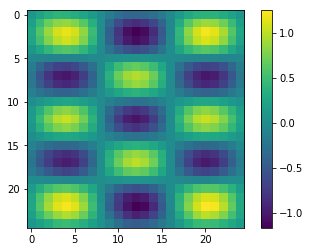

In [13]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

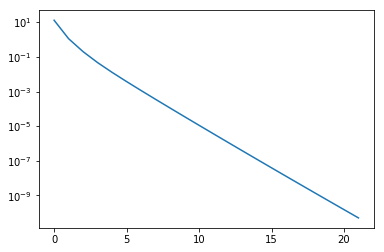

In [14]:
plt.semilogy(DMM_Res)

Radius

In [15]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.36138573691872466


In [16]:
wnew

array(0.79851879)

Rrestriction matrix after optimization

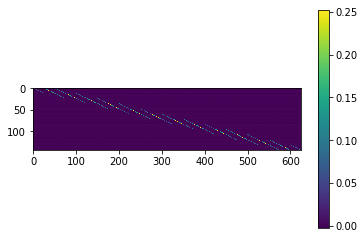

In [17]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

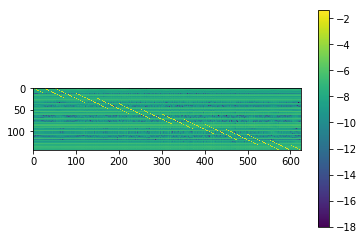

In [18]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

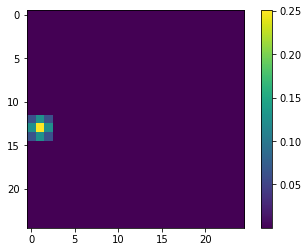

In [19]:
basis1 = Rnew[int(0.5*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

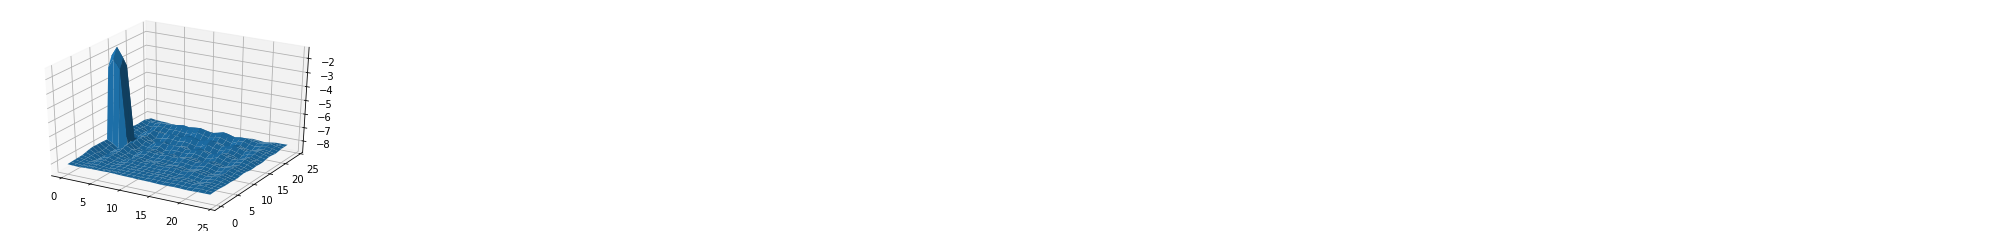

In [20]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(abs(basis1)))
plt.show()

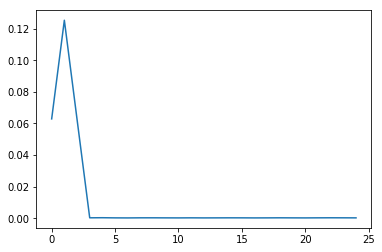

In [21]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

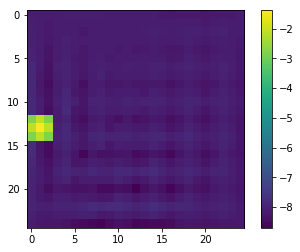

In [22]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

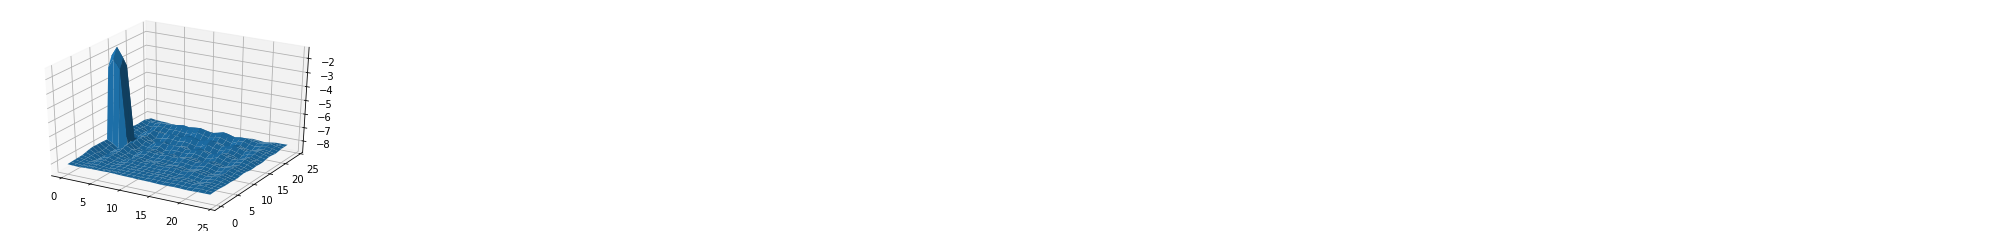

In [23]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

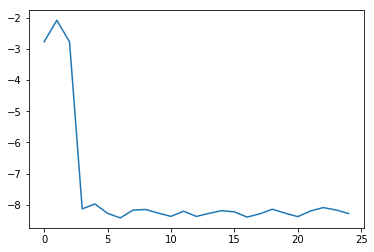

In [24]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
4.052431821887644
L2 norm: 
0.2650875146392939
H1 norm: 
2.879851666247177
Energy norm: 
0.319342101812556
L2 norm: 
0.5301750292785877
H1 norm: 
0.3201658167591819


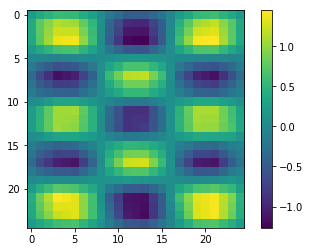

In [25]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [26]:
import os
os.system("say 'The program has finished, Please check the results'")

0